# Домашнее задание (случайный лес)

### 1. Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50, 100, 200 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote). Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

Перепишем код из методички в ООП стиле. В качестве импорта будем использовать код из предыдущего занятия

In [35]:
from sklearn import datasets, model_selection
from metrics import Metrics
from decision_tree import DecisionTree, DecisionTreeClassification, Quality
# from decision_tree import DecisionTreeClassification, Quality
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np

# import decision_tree as tree

In [36]:
class DecisionTreeForRF(DecisionTree):
    def __init__(self, quality: Quality, min_leaf: int = 5, max_count_features=None, max_depth=None,
                 max_leaves=None, bootstrap_count_features=None, random_seed=None):

        super().__init__(quality, min_leaf, max_count_features, max_depth, max_leaves)
        self.bootstrap_count_features = bootstrap_count_features
        self.full_features_count = None
        np.random.seed(random_seed)

    def fit(self, data, labels):
        self.bootstrap_count_features = self.bootstrap_count_features if not self.bootstrap_count_features \
            else int(np.sqrt(data.shape[1]))
        self.full_features_count = data.shape[1]
        self.features = list()
        self.count_leafes = 2
        self.tree = self._build_tree(data, labels)

    def __get_subfeatures(self):
        # будем сохранять не сами признаки, а их индексы
        features_indexes = [i for i in range(self.full_features_count)]

        np.random.shuffle(features_indexes)

        return [features_indexes.pop() for _ in range(self.bootstrap_count_features)]

    def __find_best_split(self, data, labels):
        current_info_criterion = self.quality.inform_criterion_method(labels)

        best_quality = 0
        best_t = None
        best_index = None

        subfeatures = self.__get_subfeatures()

        for index in subfeatures:
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique(data[:, index])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.__split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < self.min_leaf or len(false_data) < self.min_leaf:
                    continue

                current_quality = self.quality.quality(true_labels, false_labels, current_info_criterion)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index

In [37]:
class ClassifierDecisionTreeForRF(DecisionTreeForRF, DecisionTreeClassification):
    def __init__(self, quality: Quality, min_leaf: int = 5, max_count_features=None, max_depth=None,
                 max_leaves=None, bootstrap_count_features=None, random_seed=None):
        DecisionTreeForRF.__init__(self, quality, min_leaf, max_count_features, max_depth,
                                   max_leaves, bootstrap_count_features, random_seed)
        DecisionTreeClassification.__init__(self, quality, min_leaf, max_count_features, max_depth,
                                            max_leaves)

In [38]:
class RandomForest:
    def __init__(self, random_seed: int, count_tree: int, tree_class: callable, tree_quality='gini', tree_min_leaf=5,
                 tree_max_count_features=None, tree_max_depth=None, tree_max_leaves=None, bootstrap_size: int = None,
                 bootstrap_count_features: int = None):
        self.forest = list()
        self.random_seed = random_seed
        self.bootstrap_count_features = bootstrap_count_features
        self.count_tree = count_tree
        self.bootstrap_size = bootstrap_size
        np.random.seed(random_seed)
        self.full_features_count = None
        self.tree_quality = tree_quality
        self.tree_min_leaf = tree_min_leaf
        self.tree_max_count_features = tree_max_count_features
        self.tree_max_depth = tree_max_depth
        self.tree_max_leaves = tree_max_leaves
        self.tree_class = tree_class

    def fit(self, data, labels):
        if not self.bootstrap_size:
            self.bootstrap_size = data.shape[0]
        self.__get_bootstrap(data, labels)

        self.forest = list()
        bootstrap = self.__get_bootstrap(data, labels)

        for b_data, b_labels in bootstrap:
            
            model = self.tree_class(Quality(inform_criterion_method=self.tree_quality),
                                    min_leaf=self.tree_min_leaf,
                                    max_count_features=self.tree_max_count_features,
                                    max_depth=self.tree_max_depth,
                                    max_leaves=self.tree_max_leaves,
                                    bootstrap_count_features=self.bootstrap_count_features,
                                    random_seed=self.random_seed)

            model.fit(b_data, b_labels)
            self.forest.append(model)

    def __get_bootstrap(self, data: np.array, labels: np.array):
        bootstrap = []

        for i in range(self.count_tree):
            b_data = np.zeros(data.shape)
            b_labels = np.zeros(labels.shape)
            for j in range(self.bootstrap_size):
                sample_index = np.random.randint(0, data.shape[0] - 1)
                b_data[j] = data[sample_index]
                b_labels[j] = labels[sample_index]
            bootstrap.append((b_data, b_labels))

        return bootstrap

In [39]:
class ClassifierRandomForest(RandomForest):
    def __init__(self,
                 count_tree=10,
                 random_seed=None,
                 bootstrap_size=None,
                 bootstrap_count_features=None,
                 tree_quality='gini',
                 tree_min_leaf: int = 5,
                 tree_max_count_features=None,
                 tree_max_depth=None,
                 tree_max_leaves=None
                 ):
        super().__init__(random_seed=random_seed,
                         count_tree=count_tree,
                         tree_class=ClassifierDecisionTreeForRF,
                         tree_quality=tree_quality,
                         bootstrap_size=bootstrap_size,
                         bootstrap_count_features=bootstrap_count_features,
                         tree_min_leaf=tree_min_leaf,
                         tree_max_count_features=tree_max_count_features,
                         tree_max_depth=tree_max_depth,
                         tree_max_leaves=tree_max_leaves)

    def predict(self, data):

        # добавим предсказания всех деревьев в список
        predictions = []
        for tree in self.forest:
            predictions.append(tree.predict(data))

        # сформируем список с предсказаниями для каждого объекта
        predictions_per_object = list(zip(*predictions))

        # выберем в качестве итогового предсказания для каждого объекта то,
        # за которое проголосовало большинство деревьев
        voted_predictions = []
        for obj in predictions_per_object:
            voted_predictions.append(max(set(obj), key=obj.count))

        return voted_predictions

In [40]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def print_separating_plate(train_data, train_labels, test_data, test_labels,
                       model: callable, metric: callable, title=''):
    plt.figure(figsize=(16, 7))
    colors = ListedColormap(['red', 'blue'])
    light_colors = ListedColormap(['lightcoral', 'lightblue'])
    train_metrics = []
    test_metrics = []

    # график обучающей выборки
    plt.subplot(1, 2, 1)
    xx, yy = get_meshgrid(train_data)
    model.fit(train_data, train_labels)
    train_predictions = np.array(model.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, train_predictions, cmap=light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, cmap=colors)
    train_metrics = metric(train_labels, model.predict(train_data))
    plt.title(f'{title}\nTrain accuracy={train_metrics:.2f}')

    # график тестовой выборки
    plt.subplot(1, 2, 2)
    plt.pcolormesh(xx, yy, train_predictions, cmap=light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c=test_labels, cmap=colors)
    test_metrics = metric(test_labels, model.predict(test_data))
    plt.title(f'{title}\nTest accuracy={test_metrics:.2f}')
    plt.show()

    return train_metrics, test_metrics


    

Forest's size is 1


<ipython-input-40-97d8de8081b4>:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, train_predictions, cmap=light_colors)
<ipython-input-40-97d8de8081b4>:27: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, train_predictions, cmap=light_colors)


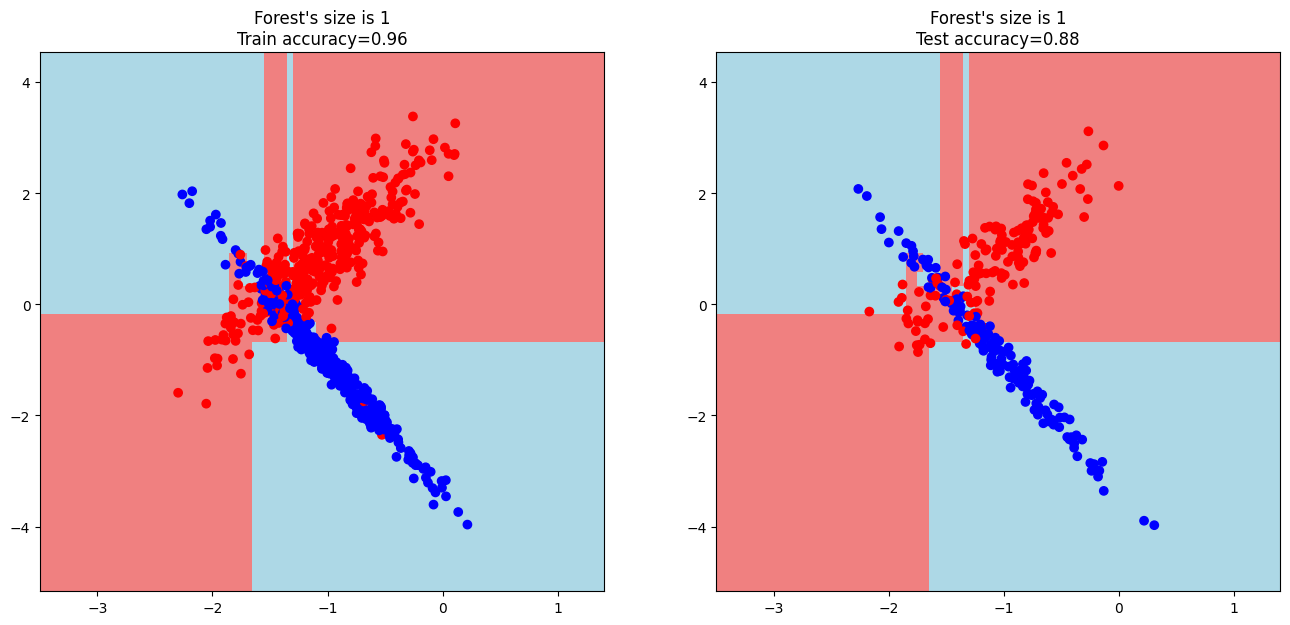

Forest's size is 3


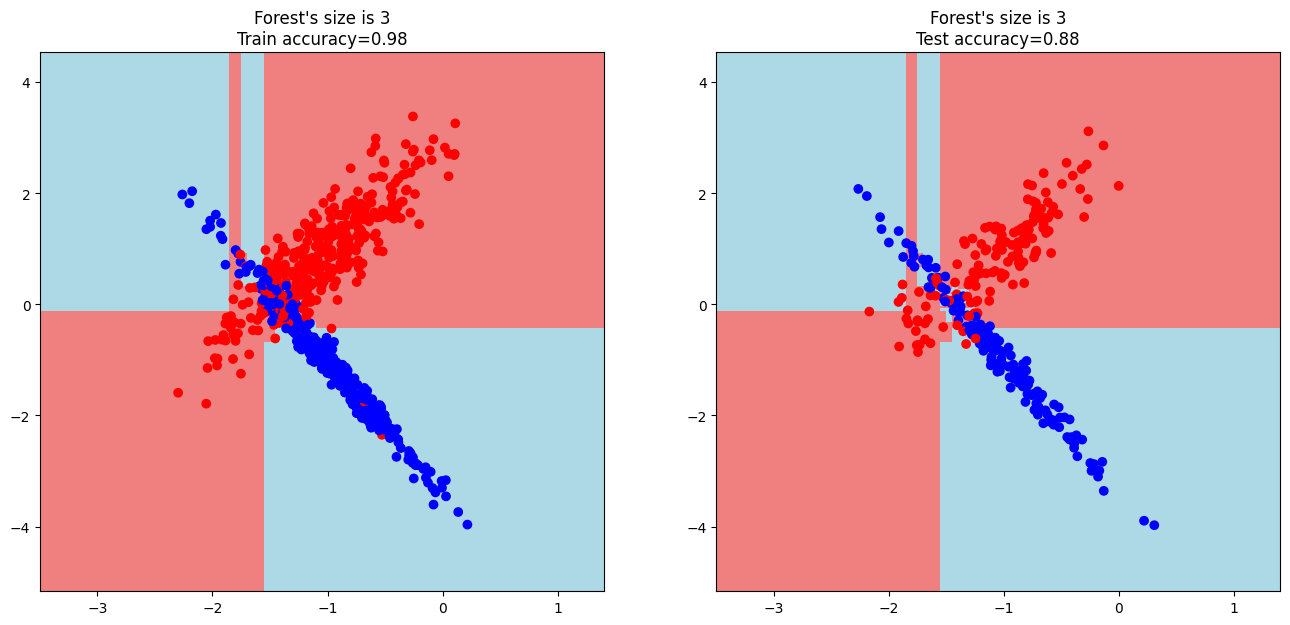

Forest's size is 10


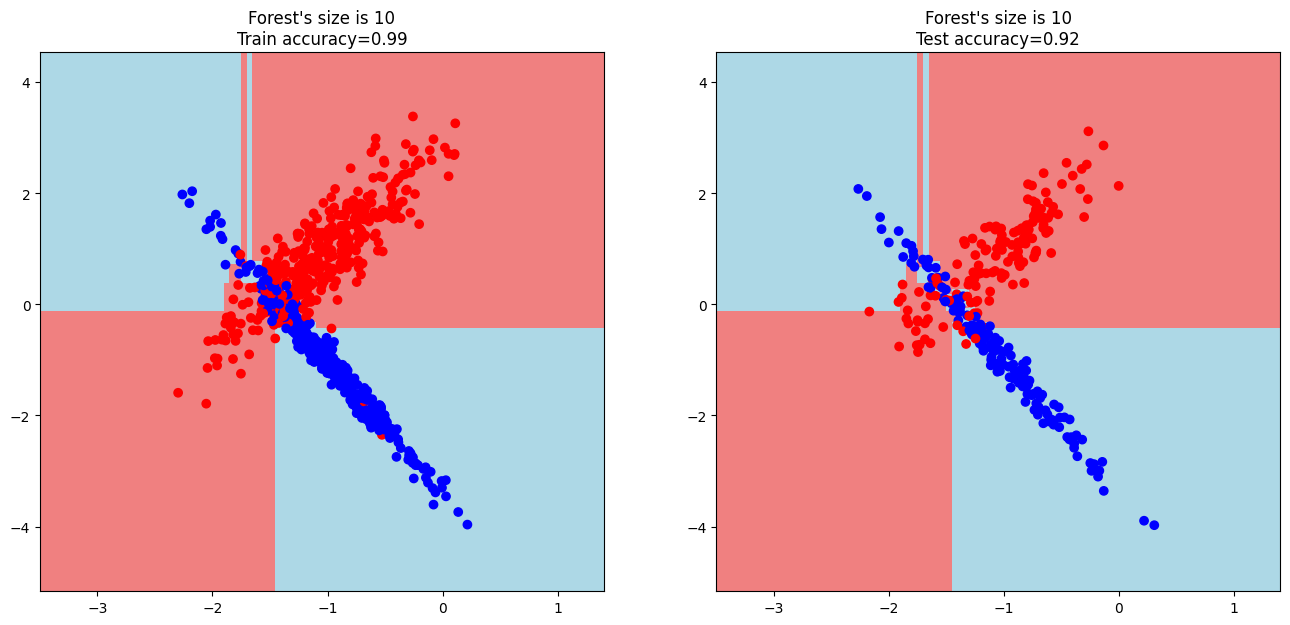

Forest's size is 50


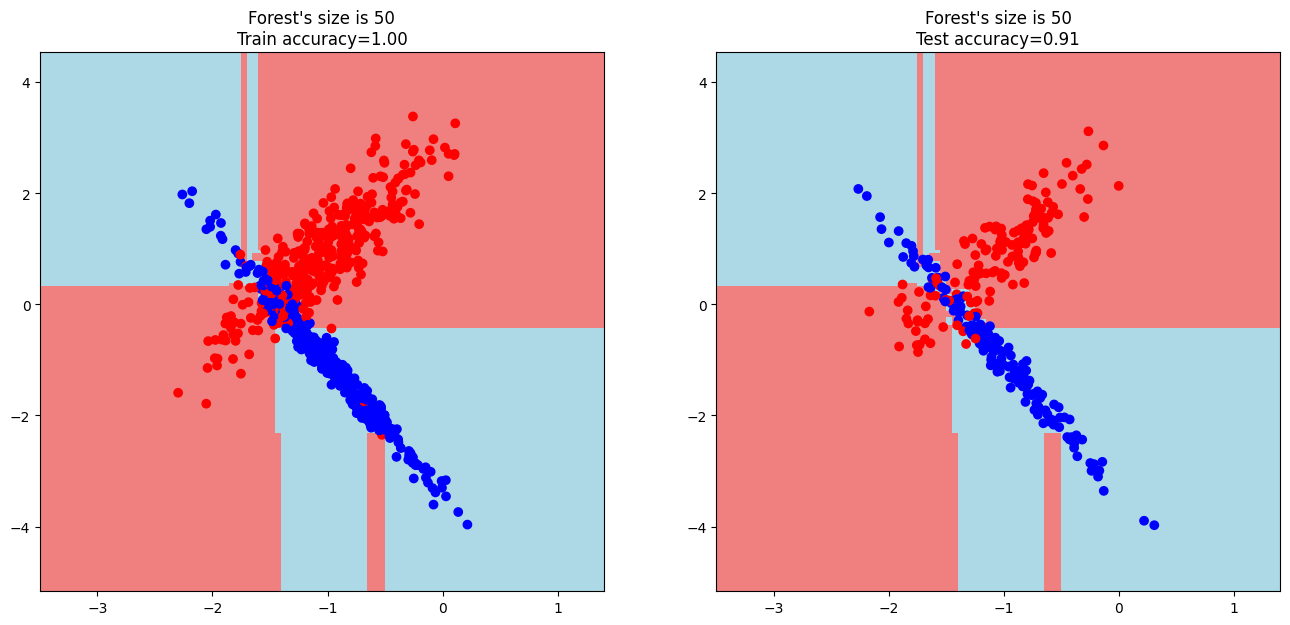

Forest's size is 100


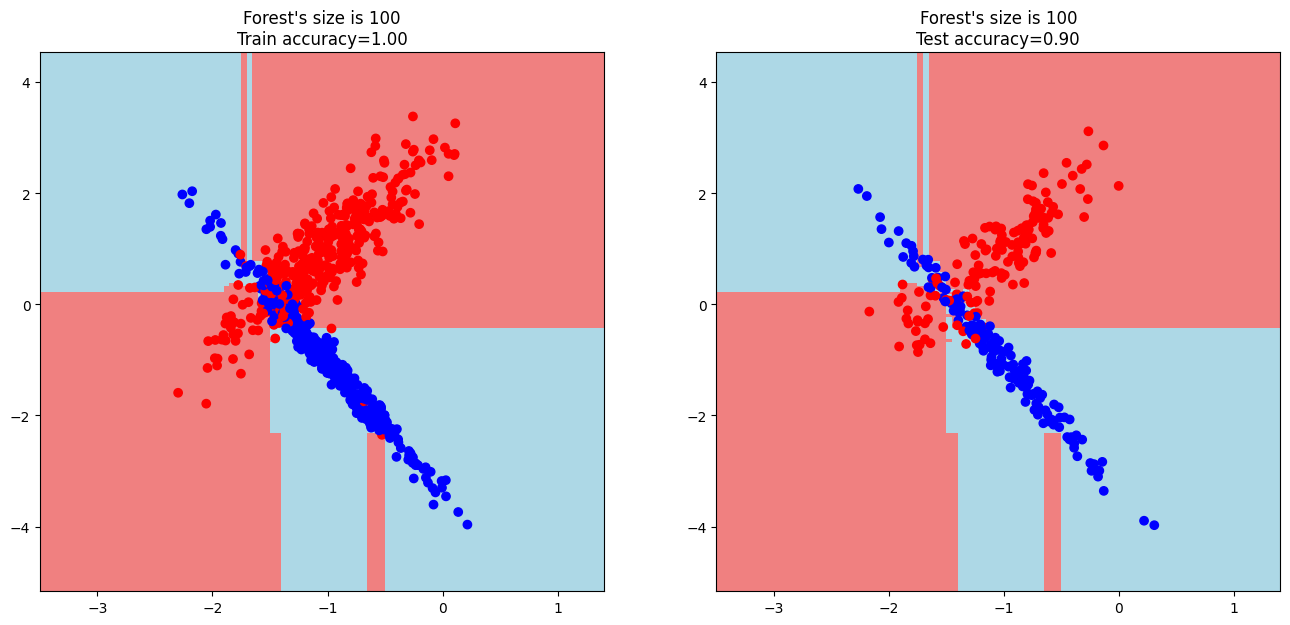

Forest's size is 200


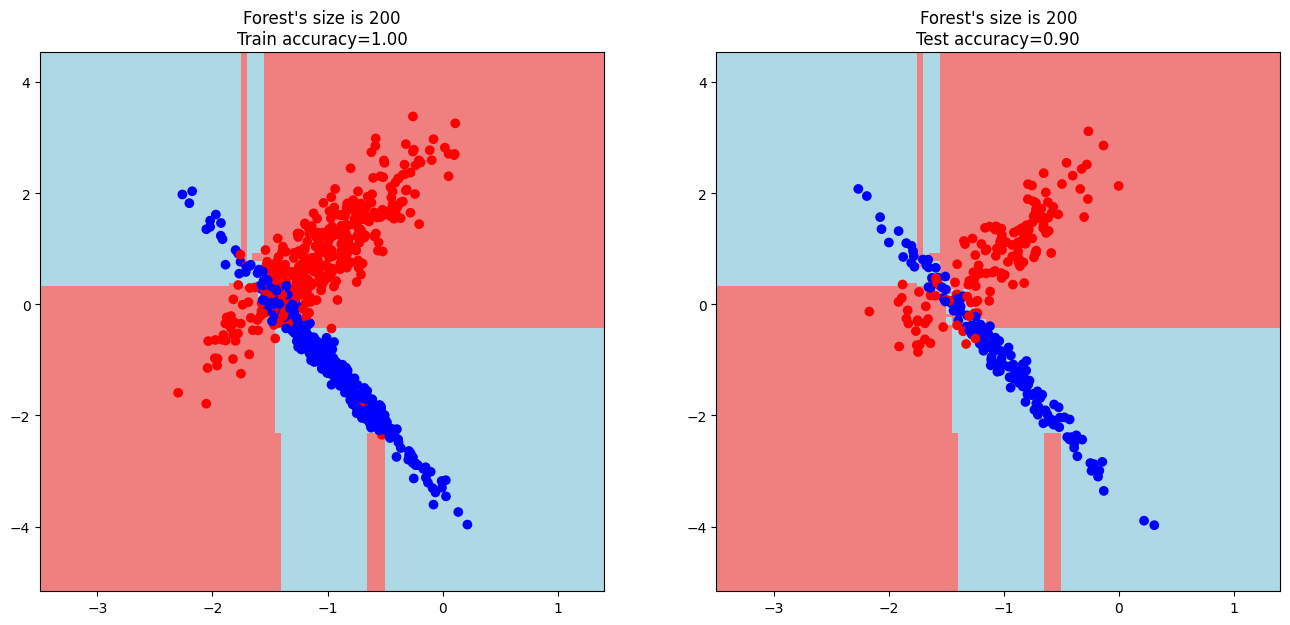

In [54]:
classification_data, classification_labels = datasets.make_classification(n_samples=1000,
                                                                          n_features=2, n_informative=2,
                                                                          n_classes=2, n_redundant=0,
                                                                          n_clusters_per_class=1, random_state=23)

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data,
                                                                                    classification_labels,
                                                                                    test_size=0.3,
                                                                                    random_state=1)

trees_count = [1, 3, 10, 50, 100, 200]
# trees_count = [1, 3]
train_accuracy, test_accuracy = list(), list()
for c_trees in trees_count:
    print(f"Forest's size is {c_trees}" )
    model = ClassifierRandomForest(random_seed=17, count_tree=c_trees, tree_min_leaf=1)
    train_accuracy_temp, test_accurace_temp = print_separating_plate(train_data, train_labels, test_data, test_labels,
                           model=model, metric=Metrics.accuracy, title=f"Forest's size is {c_trees}")
    
    train_accuracy.append(train_accuracy_temp)
    test_accuracy.append(test_accurace_temp)

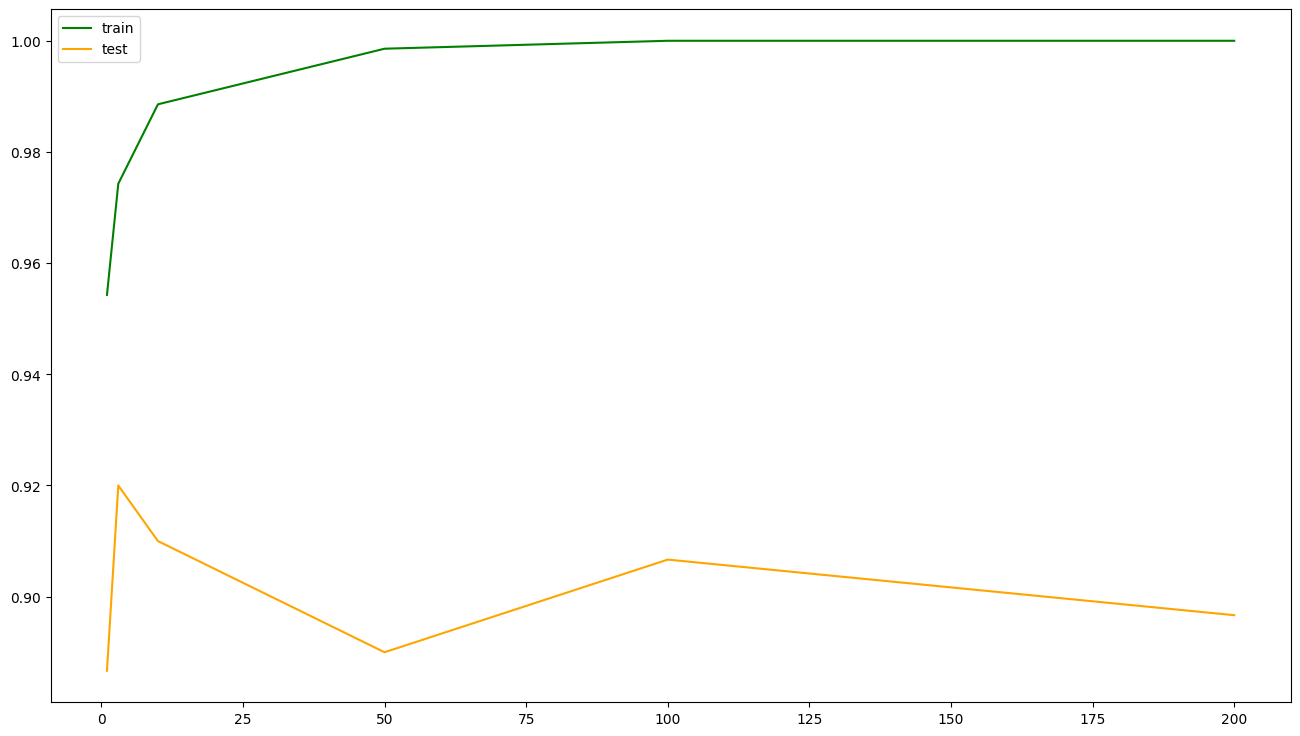

In [42]:
plt.figure(figsize=(16, 9))
plt.plot(trees_count, train_accuracy, c='green', label='train')
plt.plot(trees_count, test_accuracy, c='orange', label='test')
plt.legend()
plt.show()


Из графика видно, что зависимость точности предсказаний от количества деревьев в ансамбле нелинейная. Существуют локальные максимумы, в нашем случае максимальное значение точности на train достигается при количестве деревьев в ансамбле равное 3 

### 2 (опция). Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

Для решения этой задачи перепишем классы RandomForest, ClassifyRandomForest, DecisionTreeForRF. 

Начнем с DecisionTreeForRF. Добавим туда возможность сохранять данные, которые не попали в его обучающий bootstrap

In [43]:
class DecisionTreeForRF(DecisionTree):
    def __init__(self, quality: Quality, min_leaf: int = 5, max_count_features=None, max_depth=None,
                 max_leaves=None, bootstrap_count_features=None, random_seed=None):
        super().__init__(quality, min_leaf, max_count_features, max_depth, max_leaves)
        self.bootstrap_count_features = bootstrap_count_features
        self.full_features_count = None
        np.random.seed(random_seed)
        self.out_of_bag = None

    def fit(self, data, labels):
        self.bootstrap_count_features = self.bootstrap_count_features if not self.bootstrap_count_features \
            else int(np.sqrt(data.shape[1]))
        self.full_features_count = data.shape[1]
        self.features = list()
        self.count_leafes = 2
        self.tree = self._build_tree(data, labels)

    def __get_subfeatures(self):
        # будем сохранять не сами признаки, а их индексы
        features_indexes = [i for i in range(self.full_features_count)]

        np.random.shuffle(features_indexes)

        return [features_indexes.pop() for _ in range(self.bootstrap_count_features)]

    def __find_best_split(self, data, labels):
        current_info_criterion = self.quality.inform_criterion_method(labels)

        best_quality = 0
        best_t = None
        best_index = None

        subfeatures = self.__get_subfeatures()

        for index in subfeatures:
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique(data[:, index])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.__split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < self.min_leaf or len(false_data) < self.min_leaf:
                    continue

                current_quality = self.quality.quality(true_labels, false_labels, current_info_criterion)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index


In [44]:
class ClassifierDecisionTreeForRF(DecisionTreeForRF, DecisionTreeClassification):
    def __init__(self, quality: Quality, min_leaf: int = 5, max_count_features=None, max_depth=None,
                 max_leaves=None, bootstrap_count_features=None, random_seed=None):
        DecisionTreeForRF.__init__(self, quality, min_leaf, max_count_features, max_depth,
                                   max_leaves, bootstrap_count_features, random_seed)
        DecisionTreeClassification.__init__(self, quality, min_leaf, max_count_features, max_depth,
                                            max_leaves)

В RandomForest добавим: 
* флаг для управления out-of-bag. Если флаг установлен, то out-of-bag сохраняет наблюдения, которые не попали в bootstrap
* добавим ряд функций (get_out_of_bag_error, _get_unlearning_tree, _get_average_answer, _get_oob_error_on_observation) для подсчета OOB ошибки 

In [45]:
class NotSetOutOfBagException(Exception):
    pass

In [46]:
class RandomForest:
    def __init__(self, random_seed: int, count_tree: int, tree_class: callable, tree_quality='gini', tree_min_leaf=5,
                 tree_max_count_features=None, tree_max_depth=None, tree_max_leaves=None, bootstrap_size: int = None,
                 bootstrap_count_features: int = None, out_of_bag=False):
        self.forest = list()
        self.random_seed = random_seed
        self.bootstrap_count_features = bootstrap_count_features
        self.count_tree = count_tree
        self.bootstrap_size = bootstrap_size
        np.random.seed(random_seed)
        self.full_features_count = None
        self.tree_quality = tree_quality
        self.tree_min_leaf = tree_min_leaf
        self.tree_max_count_features = tree_max_count_features
        self.tree_max_depth = tree_max_depth
        self.tree_max_leaves = tree_max_leaves
        self.tree_class = tree_class
        self.out_of_bag = out_of_bag

    def fit(self, data, labels):
        if not self.bootstrap_size:
            self.bootstrap_size = data.shape[0]

        self.forest = list()
        bootstrap = self.__get_bootstrap(data, labels)

        for b_data, b_labels in bootstrap:
            out_of_bag = np.array([observation for observation in data if observation not in b_data]) if self.out_of_bag else None
            
            model = self.tree_class(Quality(inform_criterion_method=self.tree_quality),
                                    min_leaf=self.tree_min_leaf,
                                    max_count_features=self.tree_max_count_features,
                                    max_depth=self.tree_max_depth,
                                    max_leaves=self.tree_max_leaves,
                                    bootstrap_count_features=self.bootstrap_count_features,
                                    random_seed=self.random_seed)
            model.out_of_bag = out_of_bag

            model.fit(b_data, b_labels)
            self.forest.append(model)

    def __get_bootstrap(self, data: np.array, labels: np.array):
        bootstrap = []

        for i in range(self.count_tree):
            b_data = np.zeros(data.shape)
            b_labels = np.zeros(labels.shape)
            for j in range(self.bootstrap_size):
                sample_index = np.random.randint(0, data.shape[0] - 1)
                b_data[j] = data[sample_index]
                b_labels[j] = labels[sample_index]
            bootstrap.append((b_data, b_labels))

        return bootstrap

    def _get_unlearning_tree(self, observation: np.array) -> list:
        """
        Функция возвращает список деревьев, которые не обучались на этом наблюдении
        :param observation: наблюдение
        :return: список не обученных деревьев
        """
        return [tree for tree in self.forest if observation in tree.out_of_bag]

    def get_out_of_bag_error(self, data, labels):
        if not self.out_of_bag:
            raise NotSetOutOfBagException("Doesn't set out-of-bag flag in the constructor")

        oob_errors = list()
        for i, observation in enumerate(data):
            unlearning_tree = self._get_unlearning_tree(observation)
            average_answer = self._get_average_answer(unlearning_tree, observation)
            oob_errors.append(self._get_oob_error_on_observation(average_answer, labels[i]))

        return sum(oob_errors)

    def _get_average_answer(self, unlearning_tree: list, observation: np.array) -> float:
        """
        Функция считает среднюю ошибку деревьях на наюлюдении
        :param unlearning_tree: список деревьев, которые не обучались на переданном наблюдении
        :param observation: наблюдение
        :return: средняя ошибка
        """
        if unlearning_tree:
            return sum([tree.predict(observation.reshape((1, observation.shape[0])))[0] for tree in unlearning_tree]) \
                   / len(unlearning_tree)
        return 0

    def _get_oob_error_on_observation(self, predict_answer: float, true_answer: int) -> float:
        """
        Функция возвращает посчитаную ошибку по формуле |y_true - y_pred|
        :param predict_answer: предсказанное значение целевой переменной
        :param true_answer: правильное значение целевой переменной
        :return: значение ошибки
        """
        return np.abs(predict_answer - true_answer)

И, наконец, в ClassifierRandomForest добавим вышеупомянутый флаг out_of_bag

In [47]:
class ClassifierRandomForest(RandomForest):
    def __init__(self,
                 count_tree=10,
                 random_seed=None,
                 bootstrap_size=None,
                 bootstrap_count_features=None,
                 tree_quality='gini',
                 tree_min_leaf: int = 5,
                 tree_max_count_features=None,
                 tree_max_depth=None,
                 tree_max_leaves=None,
                 out_of_bag=False):
        super().__init__(random_seed=random_seed,
                         count_tree=count_tree,
                         tree_class=ClassifierDecisionTreeForRF,
                         tree_quality=tree_quality,
                         bootstrap_size=bootstrap_size,
                         bootstrap_count_features=bootstrap_count_features,
                         tree_min_leaf=tree_min_leaf,
                         tree_max_count_features=tree_max_count_features,
                         tree_max_depth=tree_max_depth,
                         tree_max_leaves=tree_max_leaves,
                         out_of_bag=out_of_bag)

    def predict(self, data):

        # добавим предсказания всех деревьев в список
        predictions = []
        for tree in self.forest:
            predictions.append(tree.predict(data))

        # сформируем список с предсказаниями для каждого объекта
        predictions_per_object = list(zip(*predictions))

        # выберем в качестве итогового предсказания для каждого объекта то,
        # за которое проголосовало большинство деревьев
        voted_predictions = []
        for obj in predictions_per_object:
            voted_predictions.append(max(set(obj), key=obj.count))

        return voted_predictions

In [52]:
classification_data, classification_labels = datasets.make_classification(n_samples=1000,
                                                                          n_features=2, n_informative=2,
                                                                          n_classes=2, n_redundant=0,
                                                                          n_clusters_per_class=1, random_state=23)

# train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data,
#                                                                                         classification_labels,
#                                                                                         test_size=0.3,
#                                                                                         random_state=1)

trees_count = [1, 3, 10, 50, 100, 200]
out_of_bag_error = list()
for c_trees in trees_count:
    model = ClassifierRandomForest(random_seed=17, count_tree=c_trees, tree_min_leaf=1, out_of_bag=True)
    # print_separating_plate(train_data, train_labels, test_data, test_labels,
    #                        model=model, metric=Metrics.accuracy)
    model.fit(classification_data, classification_labels)
    out_of_bag_error.append(model.get_out_of_bag_error(classification_data, classification_labels))

<Figure size 1600x900 with 0 Axes>

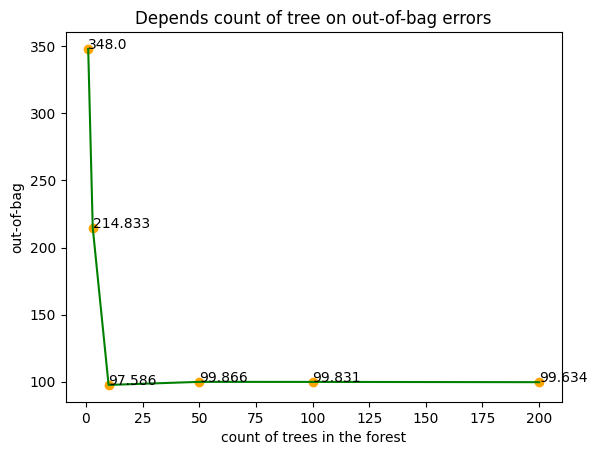

In [53]:
plt.figure(figsize=(16, 9))
fig, ax = plt.subplots()
plt.plot(trees_count, out_of_bag_error, c='green')
plt.scatter(trees_count, out_of_bag_error, c='orange')
plt.ylabel('out-of-bag')
plt.xlabel('count of trees in the forest')
for i in range(len(trees_count)):
    ax.annotate(str(round(out_of_bag_error[i], 3)), (trees_count[i], out_of_bag_error[i]))
plt.title("Depends count of tree on out-of-bag errors")
plt.show()

Из графика видно, что при значении количества деревьев в ансамбле равное 10, ошибка по out-of-bag минимизируется. Основным достоинством подбора параметров, через out-of-bag error является, то что обучение всего леса происходит на всем наборе данных